# Latent Position Two-Graph Testing

In [1]:
import numpy as np
np.random.seed(88889999)

from graspologic.inference import latent_position_test
from graspologic.embed import AdjacencySpectralEmbed
from graspologic.simulations import sbm, rdpg
from graspologic.utils import symmetrize
from graspologic.plot import heatmap, pairplot

%matplotlib inline

/opt/hostedtoolcache/Python/3.8.13/x64/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Generate a stochastic block model graph to model as a random dot product graph
To start, we generate a binary stochastic block model graph (SBM). An SBM is composed of 'communities' or 'blocks,' where a node's block membership in a graph determines its probability of connection to the other nodes in the graph.

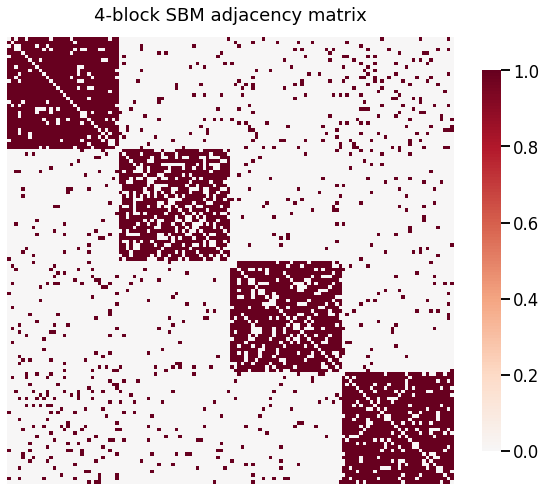

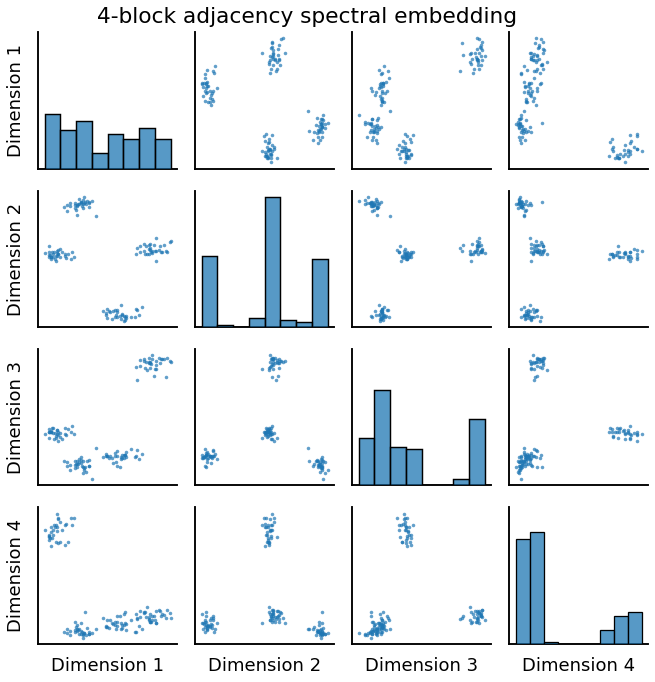

In [2]:
n_components = 4 # the number of embedding dimensions for ASE
P = np.array([[0.9, 0.11, 0.13, 0.2],
              [0, 0.7, 0.1, 0.1], 
              [0, 0, 0.8, 0.1],
              [0, 0, 0, 0.85]])

P = symmetrize(P)
csize = [32] * 4
A = sbm(csize, P)
X = AdjacencySpectralEmbed(n_components=n_components).fit_transform(A)
heatmap(A, title='4-block SBM adjacency matrix')
_ = pairplot(X, title='4-block adjacency spectral embedding')

In the adjacency matrix above, there is a clearly defined block structrure corresponding to the 4 communities in the graph that we established. Below it, we see the **adjacency spectral embedding (ASE)** of this graph. $\text{ASE}(A)$ recovers an estimate of the **latent positions** of $A$. Latent positions refer to the idea of a **random dot product graph (RDPG)** which can be modeled as follows:

For an adjacency matrix $A \in \mathbb{R}^{n \times n}$, the probability of an edge existing between node $i$ and node $j$ (aka whether or not $A_{ij}$ is a 1) is determined by the matrix $P \in \mathbb{R}^{n \times n}$

$P = XX^T$, where $X \in \mathbb{R}^{n \times d}$ and is referred to as the latent positions of the graph. $X$ is referred to as the latent positions of the graph because each node $n_i$ is modeled as having a hidden, usually unobserved location in $\mathbb{R}^d$ (we'll call it $x_i$). The probability of an edge existing between $n_i$ and $n_j$ is equal to the dot product $x_i \cdot x_j$

ASE is one way to obtain an estimate of the latent positions of a graph, $\hat{X}$

In the above embedding, we see 4 clusters of nodes corresponding to the 4 blocks that we prescribed. ASE recovers the fact that all of the nodes in a block have similar latent positions. So, RDPGs can also model an SBM graph.

## Sample new RDPGs from this latent position
Given the estimate of $X$, we now sample two new RDPGs from the same latent position above

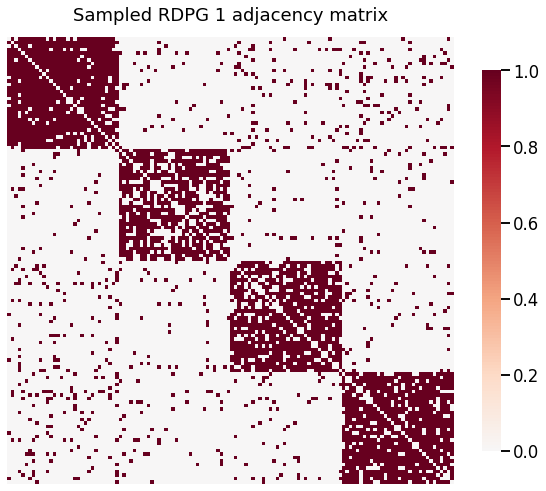

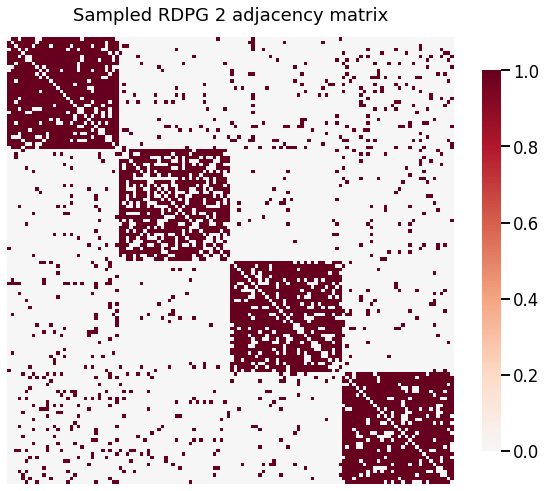

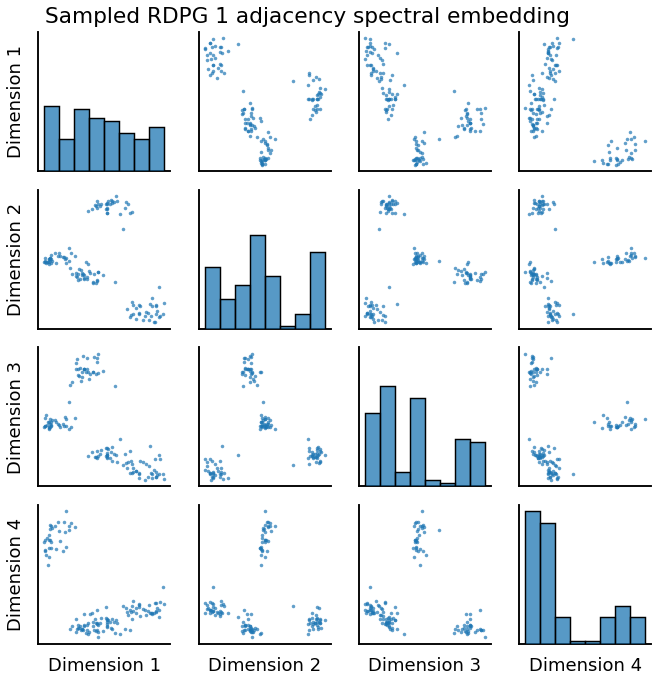

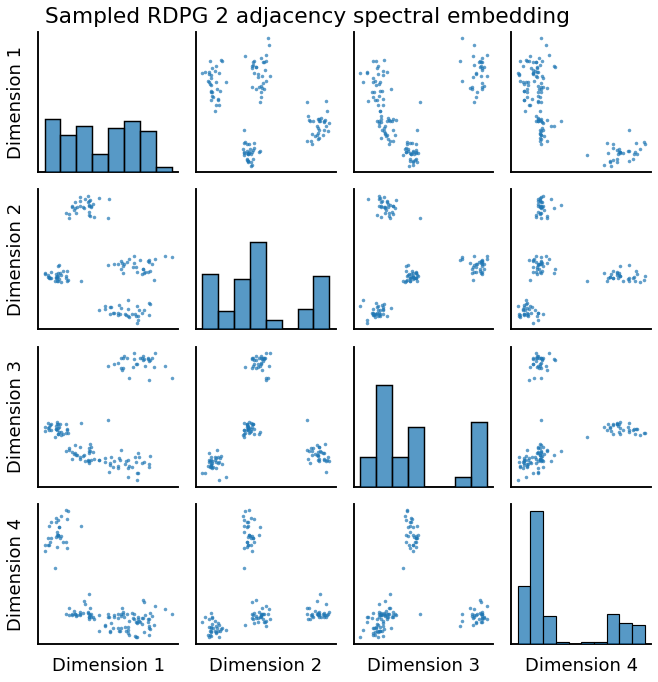

In [3]:
A1 = rdpg(X,
          loops=False,
          rescale=False,
          directed=False)
A2 = rdpg(X,
          loops=False,
          rescale=False,
          directed=False)

Xhat1 = AdjacencySpectralEmbed(n_components=n_components).fit_transform(A1)
Xhat2 = AdjacencySpectralEmbed(n_components=n_components).fit_transform(A2)

heatmap(A1, title='Sampled RDPG 1 adjacency matrix')
heatmap(A2, title='Sampled RDPG 2 adjacency matrix')
pairplot(Xhat1, title='Sampled RDPG 1 adjacency spectral embedding')
_ = pairplot(Xhat2, title='Sampled RDPG 2 adjacency spectral embedding')

Qualitatively, both of the simulated RDPGs above match the behavior we would expect, with 4 clear blocks and the corresponding 4 clusters in the embedded space. But, can we say they were generated from the same latent positions?

## Latent position test where null is true
Now, we want to know whether the above two graphs were generated from the same latent position. We know that they were, so the test should predict that the differences between Sampled RDPG 1 and 2 (up to a rotation, see below) are no greater than those differences observed by chance. In this case, we will use the `latent_position_test` in `graspologic` because we know the true alignment between the vertices of the two graphs we are testing. In other words, node $i$ in graph 1 can be thought of as equivalent to node $i$ in graph 2 because of the way we generated these graphs. 

In other words, we are testing $$ H_0: X_1 = X_2 R$$$$ H_a: X_1 \neq X_2 R$$

and want to see that the p-value for the latent position test is high (fail to reject the null)

Here, R is an orthogonal rotation matrix found from solving the [orthogonal procrustes problem](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.linalg.orthogonal_procrustes.html) (Note: this constraint can be relaxed for other versions of semipar)

Note that latent_position_test() may take several minutes

In [4]:
# note: may want to use more bootstraps in practice, low number used here is for speed
lpt = latent_position_test(A1, A2, n_bootstraps=100, n_components=n_components)
print('p = {}'.format(lpt[1]))

p = 0.801980198019802


We see that the corresponding p-value is high, indicating that the observed differences between latent positions of Sampled RDPG 1 and 2 are likely due to chance

## Matched test where the null is false

Now, we distort the latent position of one of the sampled graphs by adding noise. The matched test should have a low p-value, indicating that we should reject the null hypothesis

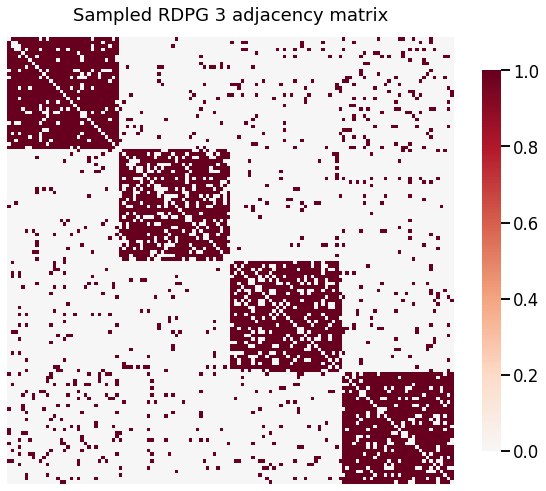

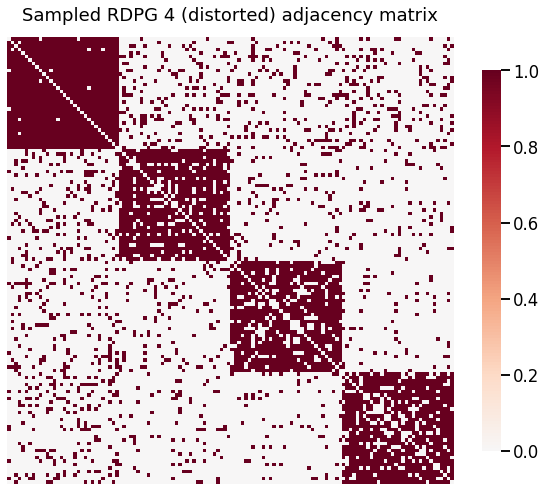

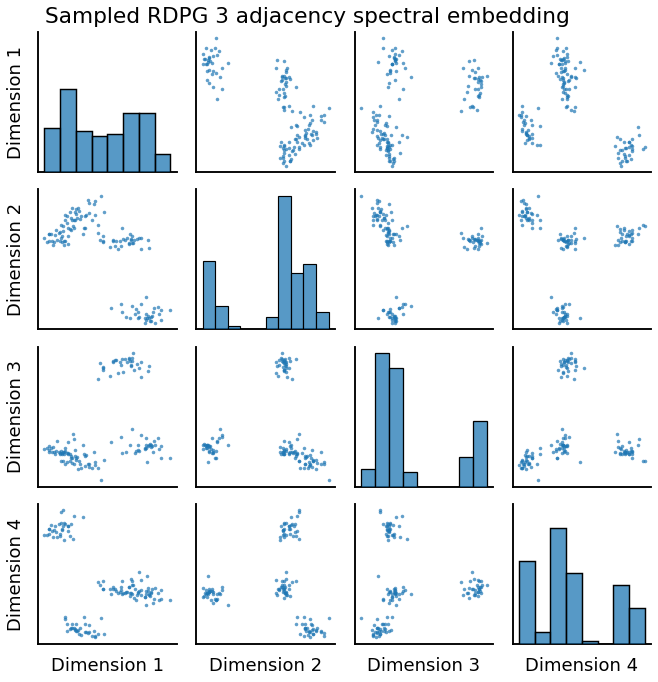

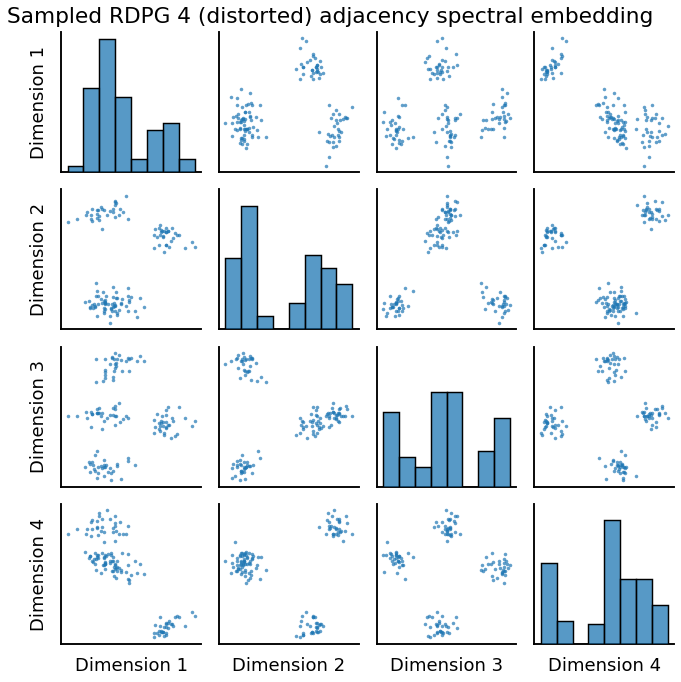

In [5]:
A3 = rdpg(X,
          loops=False,
          rescale=False,
          directed=False)
A4 = rdpg(X + np.random.normal(0.05, 0.02, size=(X.shape)),
          loops=False,
          rescale=False,
          directed=False)

Xhat3 = AdjacencySpectralEmbed(n_components=n_components).fit_transform(A3)
Xhat4 = AdjacencySpectralEmbed(n_components=n_components).fit_transform(A4)

heatmap(A3, title='Sampled RDPG 3 adjacency matrix')
heatmap(A4, title='Sampled RDPG 4 (distorted) adjacency matrix')
pairplot(Xhat3, title='Sampled RDPG 3 adjacency spectral embedding')
_ = pairplot(Xhat4, title='Sampled RDPG 4 (distorted) adjacency spectral embedding')

In [6]:
# note: may want to use more bootstraps in practice, low number used here is for speed
lpt = latent_position_test(A3, A4, n_bootstraps=100, n_components=n_components)
print('p = {}'.format(lpt[1]))

p = 0.07920792079207921
